# **Dart Target**

**Description**

Detect the coordinates of this dart target center

**Group 13**

Nelson José Marques Martins Almeida pg52697

Carlos Gustavo Silva Pereira pg53723

In [72]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np

Lets start by importing our image

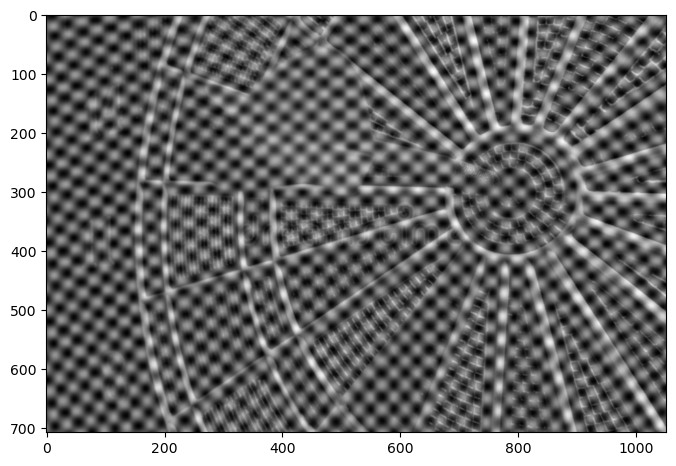

In [73]:
fname = 'DartTarget-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
W,H=img.shape
ratio=H/W
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')

### We can easily verify that the image has a *Moiré* pattern that inhibts us from properly locating the bullseye

In order to reduce/eliminate the *Moiré Effect*, we will use a *Discrete Fourier Transform* to eliminate the "contaminating" frequencies

Text(0.5, 1.0, 'Magnitude Spectrum')

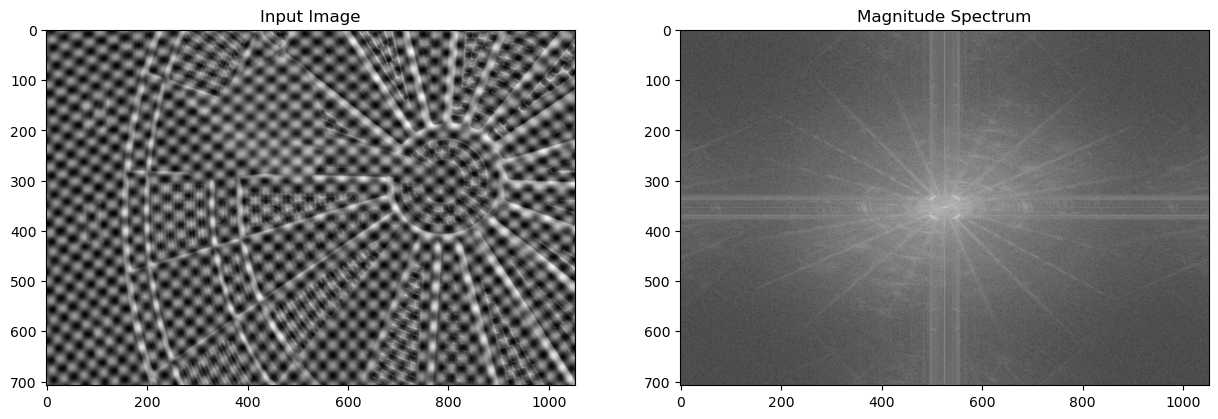

In [74]:
# convert the image representation to SPFP
img_float = np.float32(img)

# calculate the Discrete Fourier Transform of the image
dft = cv2.dft(img_float, flags = cv2.DFT_COMPLEX_OUTPUT)

# center the DFT in (0,0)
dft_shift = np.fft.fftshift(dft)

# calculate the magnitude spectrum
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])

# apply the logarithmic function to enchance the visualization of the darker pixels
magnitude_spectrum = 20*np.log(magnitude_spectrum) 

# display of the original image and the magnitude spectrum
f, axarr = plt.subplots(1,2,figsize=(15,15*ratio))
axarr[0].imshow(img, cmap='gray')
axarr[0].set_title('Input Image')
axarr[1].imshow(magnitude_spectrum, cmap='gray')
axarr[1].set_title('Magnitude Spectrum')

#### As we can see by the images above, the hotspots in the spectral space have a higher intensity.
If we supress these spots, using Notch Filters, we'll obtain the corrected image.

## **Hostspot detection**

In order to find the right Notch Filter placement, we need to detect the hotspots that cause the Moiré Effect.

In [75]:

hotspots = []
averageLightning = np.percentile(magnitude_spectrum, 99.5) # 99.5% of the pixels are below this value

# Detect the hotspots in the image, neglecting the center
# We'll only consider the top-left quadrant of the magnitude spectrum since the magnitude spectrum is reflected in all axis
for i in range(1, magnitude_spectrum.shape[0] // 2):
    for j in range(1, magnitude_spectrum.shape[1] // 2):
        if magnitude_spectrum[i][j] >= averageLightning:
            hotspots.append((i, j))


# This "bruteforce" algorithm shrinks the number of hotspots until it finds the desired number of hotspots by altering the delta value
# The delta represents the "shift" in brightness from one pixel to its neighbour
def bruteforce_search(magnitude_spectrum, hotspots, target=1):
    hotspotsBoxes = hotspots
    box = []
    delta = 0
    while(len(hotspotsBoxes) > target):
        box=[]
        hotspotsBoxes=[]
        for i in range(len(hotspots) - 1):
            # exclude the points near the center so that the bright spectrum values doesn't interfere 
            if abs(hotspots[i][0]-magnitude_spectrum.shape[0]//2) < 10 and abs(hotspots[i][1]-magnitude_spectrum.shape[1]//2) < 10:
                continue
            elif abs(hotspots[i][0] - hotspots[i + 1][0]) < delta and abs(hotspots[i][1] - hotspots[i + 1][1]) < delta :
                box.append(hotspots[i])
            else:
                box.append(hotspots[i])
                hotspotsBoxes.append(box)
                box = []
        delta += 0.5

    # box the hotspots and select the one with the highest intensity
    hotspotPerBox = []
    for box in hotspotsBoxes:
        maxLightning = 0
        hotpostIndex = 0
        for i in range(len(box)):
            if magnitude_spectrum[box[i][0]][box[i][1]] > maxLightning:
                maxLightning = magnitude_spectrum[box[i][0]][box[i][1]]
                hotpostIndex = i
        hotspotPerBox.append(box[hotpostIndex])
   
    return hotspotPerBox

# run the bruteforce hotspot search
hotspots = bruteforce_search(magnitude_spectrum, hotspots=hotspots, target=1)


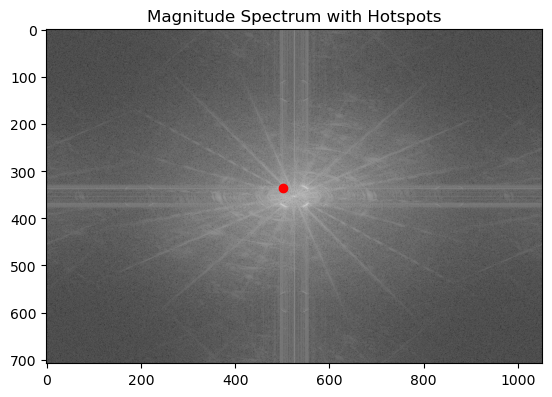

In [76]:
# plot the discovered hotspots
x = [hotspot[1] for hotspot in hotspots]
y = [hotspot[0] for hotspot in hotspots]
plt.scatter(x, y, color='red')
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum with Hotspots')
plt.show()

As we can see, we found the correct spot of the hotspot in the magnitude spectrum of the image.

## **Ghost detection**

Now we have to determine the ghosts of said hotspots.

Our approach involves thresholding the magnitude spectrum so that "ghost" hotspots become more visible.

In [77]:
threshold = 127
# threshold the image so we can detect the ghosts easier since their current state doesn't help in their identification
magnitude_spectrum = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
ret,th1 = cv2.threshold(magnitude_spectrum,threshold,255,cv2.THRESH_BINARY)

After that, we'll search the "ghost" hotspots, starting from the top of the image and going down (on the vertical axis) until we find the first ghost.

If we find a ghost with another ghost below it (with a distance equal to 2*y+delta), then we have found what we've called a "full ghost".
Otherwise, we'll assume that the other piece of the "full ghost" is out of bounds and we have found the lower piece of  it.

**Disclaimer:** the magnitude spectrum ghosts repeat periodically in all axis. We opted to detect the ghosts in the vertical axis only in order to keep the solution simple.

In [78]:
# detect the ghosts by looking for the first pixel with a higher lightning than the threshold
hotspotsGhosts = {}
for hotspot in hotspots:

    hotspotsGhosts[hotspot] = []
    x = hotspot[1]
    y = hotspot[0]
    ghostFound = False

    for y1 in range(0,y):
        averageLightning = np.average([th1[y1][x1] for x1 in range(x-2,x+2)])
        if averageLightning > threshold:
            hotspotsGhosts[hotspot].append((y1,x))
            ghostFound=True
            break

    distanceToCenter = abs(y-th1.shape[0]//2)
    if ghostFound:
        #If the ghost was found then we have to verify if there is another piece of the ghost in 2*y+delta
        #If the distance to verify is equal to the original ghost, then it is a full ghost
        #Else it may be "lost" or out of bounds
        delta=5
        for i in range(y1+2*(distanceToCenter), y1+2*(distanceToCenter)+delta):
            averageLightning = np.average([th1[i][x1] for x1 in range(x-2,x+2)])
            if averageLightning > threshold:
                hotspotsGhosts[hotspot].append((i,x))
                secondGhostx = x
                secondGhosty = i
        
                break

Let's plot the discovered ghosts.

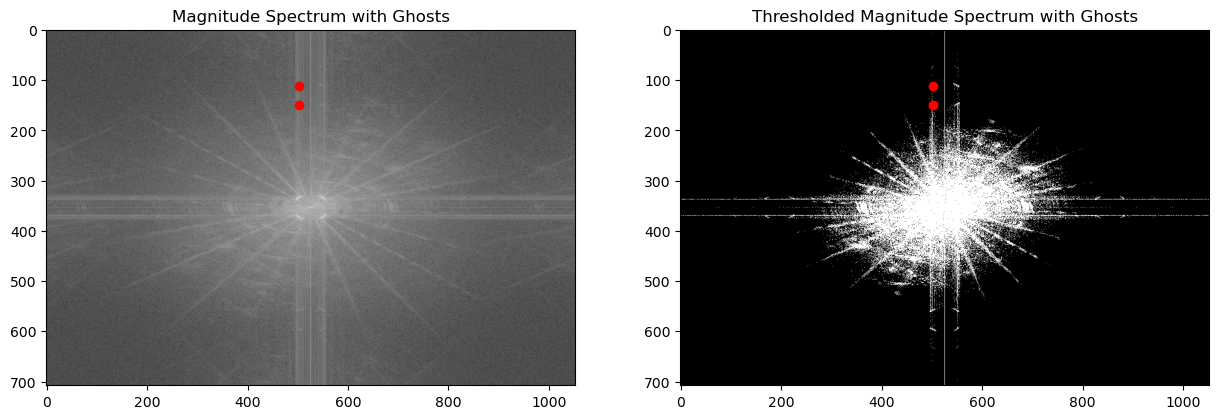

In [79]:
# plot the discovered ghosts
f, axarr = plt.subplots(1,2,figsize=(15,15*ratio))

axarr[0].imshow(magnitude_spectrum, cmap='gray')
axarr[0].set_title("Magnitude Spectrum with Ghosts")

axarr[1].imshow(th1, cmap='gray')
axarr[1].set_title("Thresholded Magnitude Spectrum with Ghosts")

for hotspot in hotspots:
    x = hotspot[1]
    y = hotspot[0]
    ghostFound = False

    for y1 in range(0,y):
        averageLightning = np.average([th1[y1][x1] for x1 in range(x-2,x+2)])
        if averageLightning > threshold:
            hotspotsGhosts[hotspot].append((y1,x))
            ghostFound=True

            # for plotting purposes
            axarr[0].scatter(x, y1, color='red')
            axarr[1].scatter(x, y1, color='red')
            
            break

    distanceToCenter = abs(y-th1.shape[0]//2)
    if ghostFound:
        delta=5
        for i in range(y1+2*(distanceToCenter), y1+2*(distanceToCenter)+delta):
            averageLightning = np.average([th1[i][x1] for x1 in range(x-2,x+2)])
            if averageLightning > threshold:
                hotspotsGhosts[hotspot].append((i,x))

                # for plotting purposes
                axarr[0].scatter(x, i, color='red')
                axarr[1].scatter(x, i, color='red')

                break

plt.show()

We'll create the Notch Filter vectors based on the hotspots positions.

This helper function will apply the filters for the rest of the quadrants (since the magnitude spectrum is simetrical).

In [80]:

def notch_reject_filter_vec(shape: tuple[int, int], d0: int, u_k: int, v_k: int):
    (W, H) = shape

    H_0_u = np.repeat(np.arange(W), H).reshape((W, H))
    H_0_v = np.repeat(np.arange(H), W).reshape((H, W)).transpose()

    D_uv = np.sqrt((H_0_u - W / 2 + u_k) ** 2 + (H_0_v - H / 2 + v_k) ** 2)
    D_muv = np.sqrt((H_0_u - W / 2 - u_k) ** 2 + (H_0_v - H / 2 - v_k) ** 2)

    selector_1 = D_uv <= d0
    selector_2 = D_muv <= d0

    selector = np.logical_or(selector_1, selector_2)

    H = np.ones((W, H, 2), np.uint8)
    H[selector] = 0

    return H

Theoretically, we should determine the best notch filter radius and this should change through the ghosts since they fade as we move away from (0,0).

Through experimentation, we saw no difference in the resulting image, therefore we won't add complexity to the solution by trying to find those values.

In [81]:

# d0 represents the notch filters radius
d0_list = []
# u_k_list array stores the distance from the center of the image in order to the x axis
u_k_list = []
# v_k_list array stores the distance from the center of the image in order to the y axis
v_k_list = []

# U=x (horizontal axis)
# V=y (vertical axis)

for i in hotspots:
    xDistanceToCenter = abs((img.shape[1]//2)-i[1])
    yDistanceToCenter = abs((img.shape[0]//2)-i[0])

    d0_list.append(9)
    d0_list.append(9)
    
    v_k_list.append(-xDistanceToCenter)
    v_k_list.append(xDistanceToCenter)

    u_k_list.append(yDistanceToCenter)
    u_k_list.append(yDistanceToCenter)
    
    # apply the notch filter to the ghosts
    for j in hotspotsGhosts[i]:   
        yDistanceToCenter = abs((img.shape[0]//2)-j[0])

        d0_list.append(9)
        d0_list.append(9)

        v_k_list.append(-xDistanceToCenter)
        v_k_list.append(xDistanceToCenter)

        u_k_list.append(yDistanceToCenter)
        u_k_list.append(yDistanceToCenter)

# apply the notch filter to the hotspots
H = notch_reject_filter_vec (img.shape, d0_list[0], u_k_list[0], v_k_list[0])

for d0, u_k, v_k in zip (d0_list[1:], u_k_list[1:], v_k_list[1:]):
    Haux = notch_reject_filter_vec (img.shape, d0, u_k, v_k)
    H *= Haux


# apply mask and inverse DFT
dft_masked = dft_shift*H
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

In [82]:
# compute the DFT of the processed image (img_back)
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft_proc = cv2.dft(img_back, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_proc_shift = np.fft.fftshift(dft_proc)
# compute the frequency spectrum
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum)

/tmp/ipykernel_3087/944813590.py:12: RuntimeWarning: divide by zero encountered in log
  filtered_spectrum = 20*np.log(filtered_spectrum)


In [83]:
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(H[:,:,0],2)+np.power(H[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

Let's plot the results of the image correction using Notch Filters.

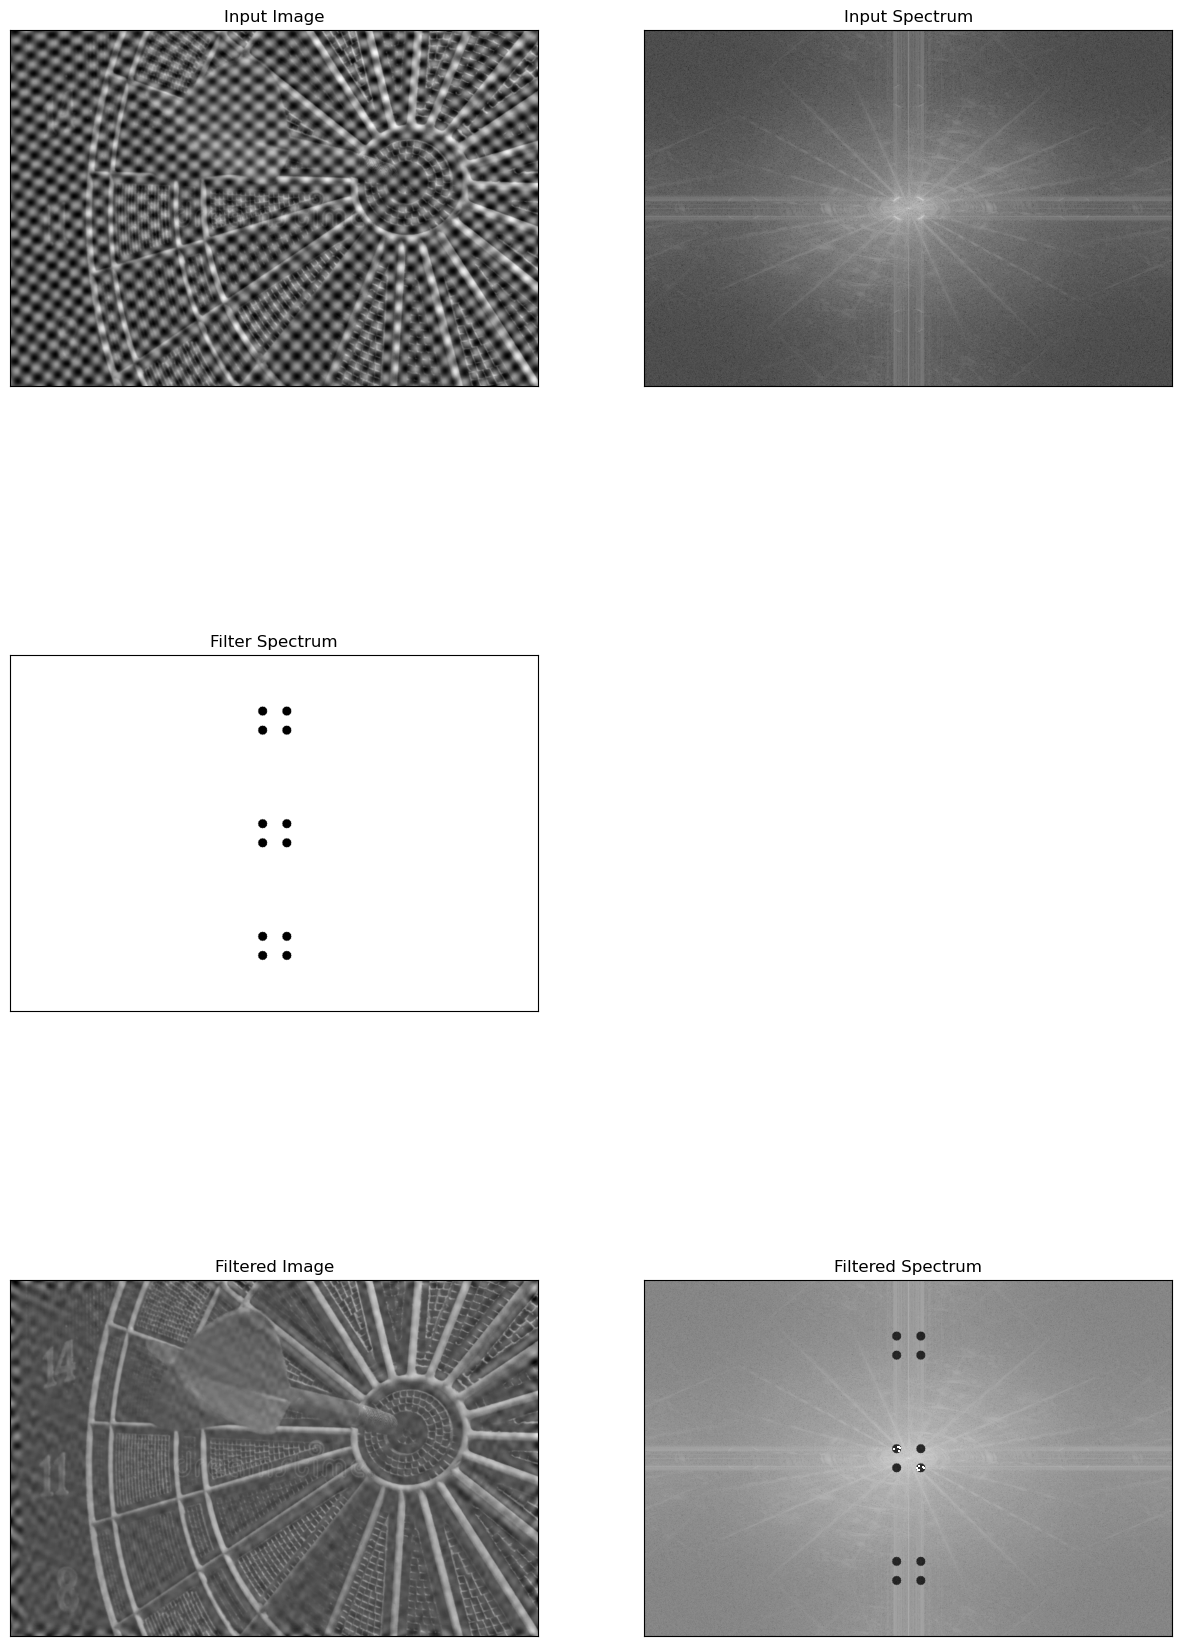

In [84]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(325),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])

plt.subplot(326),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()         

## Bullseye detection

Now that we have reduced the Moiré effect noise we can try to identify the bullseye.

To achieve this we will threshold the image and apply a average based filter to eliminate the noise generated by the unwanted elements from the backboard. We only want to keep the structure/rim of the dart target.

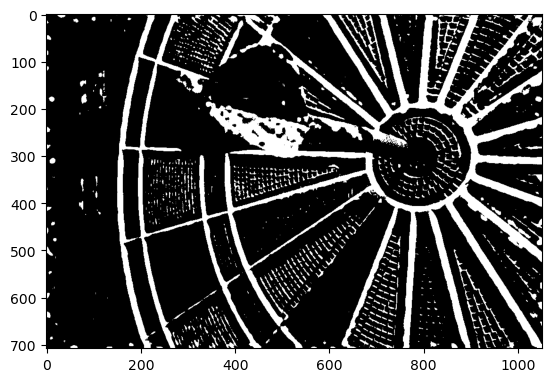

In [85]:
img_clean = img_back.copy()

# Normalize the image
img_clean = cv2.normalize(img_clean, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

_, img_clean = cv2.threshold(img_clean, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(img_clean, cmap='gray')
img2 = img_clean.copy()

We'll binarize the image by applying a filter in order to remove the backboard from the image.

For each pixel, if the average of its neighbours is lower than a threshold, we will set it to 0.

We'll also remove the borders since they were introduce noise even after the filtering process.

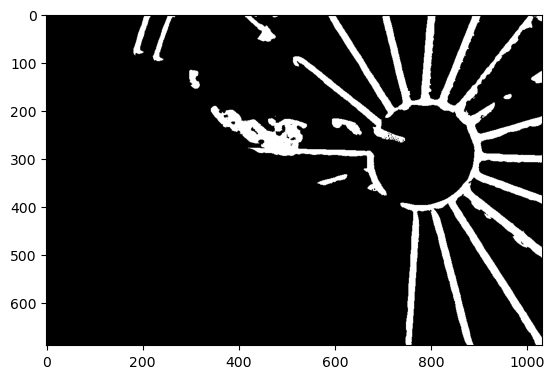

In [86]:
for i in range(9, img_clean.shape[0] - 9):
    for j in range(9, img_clean.shape[1] - 9):
        if np.average(img_clean[i-9:i+9, j-9:j+9]) < 120:
            img_clean[i, j] = 0

# remove the borders
img_clean = img_clean[10:-10, 10:-10]

plt.imshow(img_clean, cmap='gray')
img2 = img_clean.copy()

Now that we have an image that only has the circle that we want we will apply the Hough Circles function provided by the OpenCV library.

This function is based in the Hough Transform but directed to finding circles in images.

**The parameters are the following:**

- cv2.HOUGH_GRADIENT - the method to detect the circles
- 3 - The inverse ratio of the accumulator resolution to the image resolution
- 50 - The minimum distance between the centers of the detected circles
- param1 - The higher threshold of the two passed to the Canny edge detector
- param2 - The accumulator threshold for the circle centers at the detection stage

We've fine tuned this parameters to achieve the best results. By setting the minimum radius to 5 we neglected the smaller circles that came from the noise of the image like the remainings of the dart flight.

1


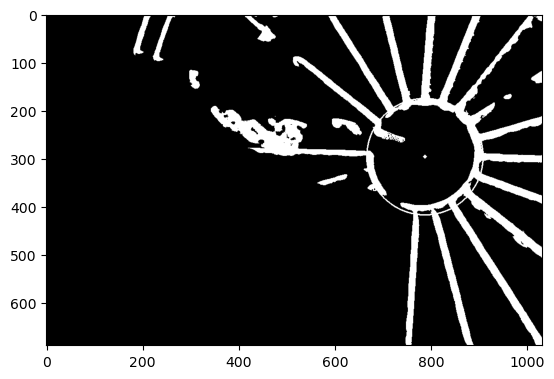

In [87]:
circles = cv2.HoughCircles(img2, cv2.HOUGH_GRADIENT,
                            3, 50, 
                            param1=1000, param2=150, 
                            minRadius=5, maxRadius=img_clean.shape[0]//4)

#Draw the circles
if circles is not None:
    print(len(circles[0]))
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # draw the outer circle
        cv2.circle(img2, (i[0], i[1]), i[2], (255, 0, 0), 2)
        # draw the center of the circle
        cv2.circle(img2, (i[0], i[1]), 2, (255, 0, 0), 3)
#plot the image
plt.imshow(img2, cmap='gray')
plt.show()

As we can see from the drawing above the resulting circle appear to correspond to the dart board's outer bull ring, having it's center in the bullseye.

In [92]:
center = (circles[0, 0, 0],circles[0, 0, 1])
print(center)


(788, 296)


## **Result**
The center is aproximately in the point (788, 296).

Let's check if it matches with the center of the dart board.

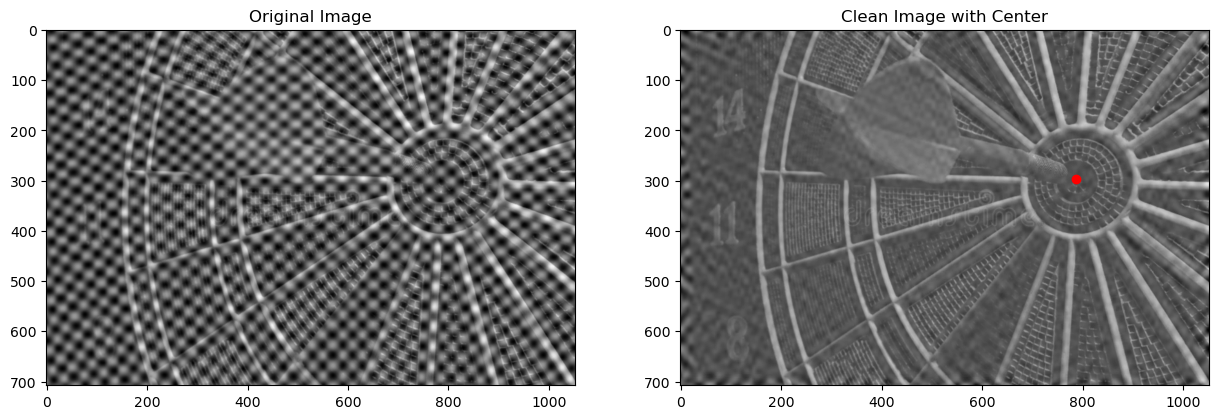

In [93]:
# plot the clean image and the center that we discovered
f, axarr = plt.subplots(1,2,figsize=(15,15*ratio))
axarr[0].imshow(img, cmap='gray')
axarr[0].set_title('Original Image')
axarr[1].imshow(img_back, cmap='gray')
axarr[1].set_title('Clean Image with Center')
plt.scatter(center[0], center[1], color='red')
plt.show()

That's all, Folks!